In [1]:
import os, sys
path = os.path.abspath(os.path.join('..'))
os.chdir(path)
if path not in sys.path:
    sys.path.append(path)

In [2]:
import matplotlib.pyplot as plt
import niceplots
plt.style.use(niceplots.get_style())

from pathlib import Path
from optim import TopOpt, Post3D

ANSYS_path = Path("mapdl")
res_dir    = Path("results/subs/")
mod_dir    = Path("models/")
TopOpt.set_paths(ANSYS_path, res_dir, mod_dir)

# Fibreglass

Parts with geometrical function, optimisation with volfrac 0.35

- Traditional composite: S-glass + polyester, fibre volume fraction 0.5
- Eco-optimised: bamboo + cellulose, fibre volume fraction 0.5


Compliance : 569.51 N.mm
Mass : 72.51 g
CO2 footprint: 7151.04 kgCO2


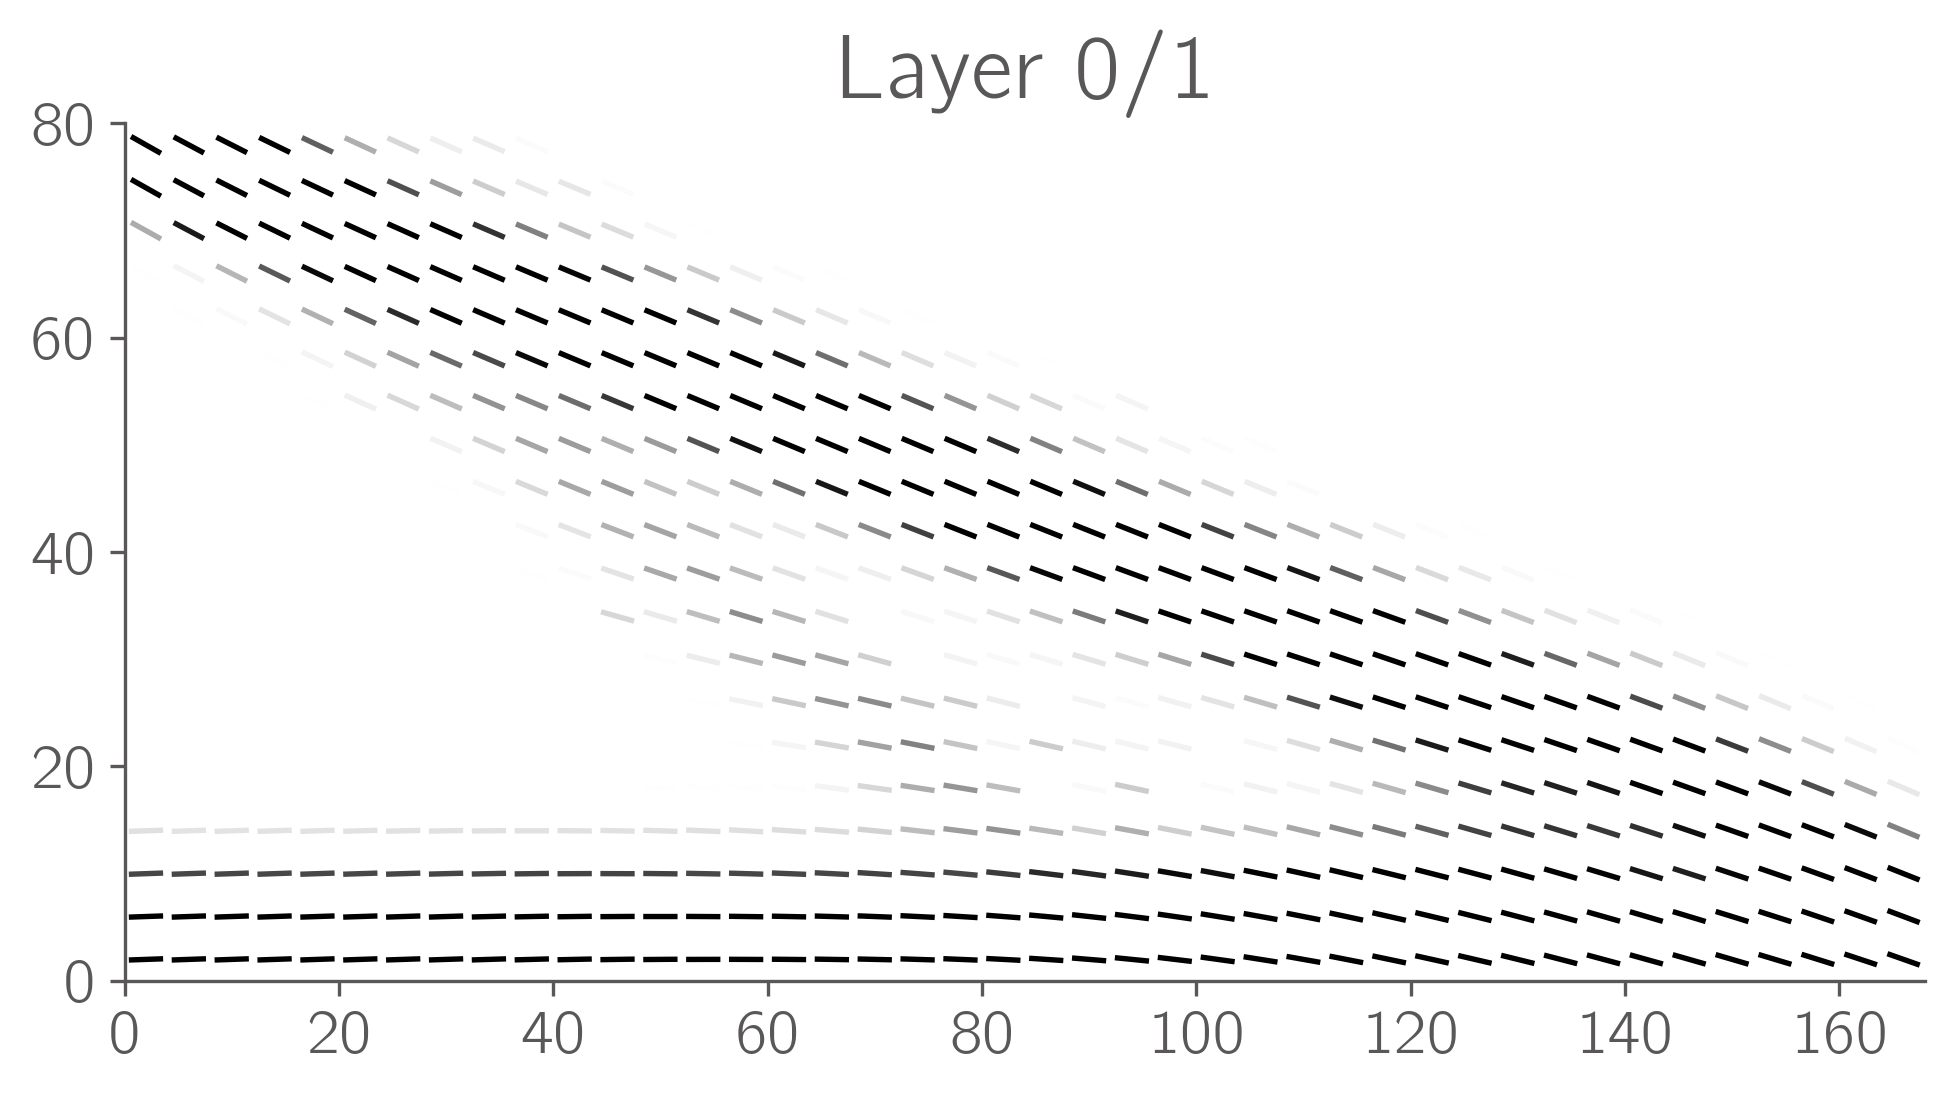

In [3]:
# {t/mm^3, MPa, -, kgCO2/kg}
sglass     = {'rho': 2495e-12, 'E': 89.5e3, 'v': 0.22, 'CO2': 2.905}
polyester  = {'rho': 1385e-12, 'E': 4.55e3, 'v': 0.35, 'CO2': 4.5}
Vfiber  = 0.5

Ex, Ey, nuxy, nuyz, Gxy, rho, CO2mat = TopOpt.rule_mixtures(fiber=sglass, matrix=polyester, Vfiber=Vfiber)
CO2veh = 1030 * 25 * 3.83 # kg_fuel/kg_transported/year * years * kgCO2/kg_fuel = kgCO2/kg

solver = TopOpt(inputfiles='mbb3d', dim='3D_layer', jobname='glass', echo=False)
solver.set_material(Ex=Ex, Ey=Ey, nuxy=nuxy, nuyz=nuxy, Gxy=Gxy)
solver.set_volfrac(0.35)
solver.set_filters(r_rho=6, r_theta=40)
solver.set_initial_conditions('random')
solver.set_optim_options(max_iter=150, tol=1e-3, continuation=True)
solver.create_optimizer()

solver.run()
solver.save()
comp = solver.comp_max_hist[-1]
        
post = Post3D(solver)
post.plot_layer(layer=0)

print()
print('Compliance : {:.2f} N.mm'.format(comp))
print('Mass : {:.2f} g'.format(1e6 * solver.get_mass(rho)))
print('CO2 footprint: {:.2f} kgCO2'.format(1000 * solver.get_CO2_footprint(rho, CO2mat, CO2veh)))


Compliance : 2050.29 N.mm
Mass : 31.70 g
CO2 footprint: 3126.02 kgCO2


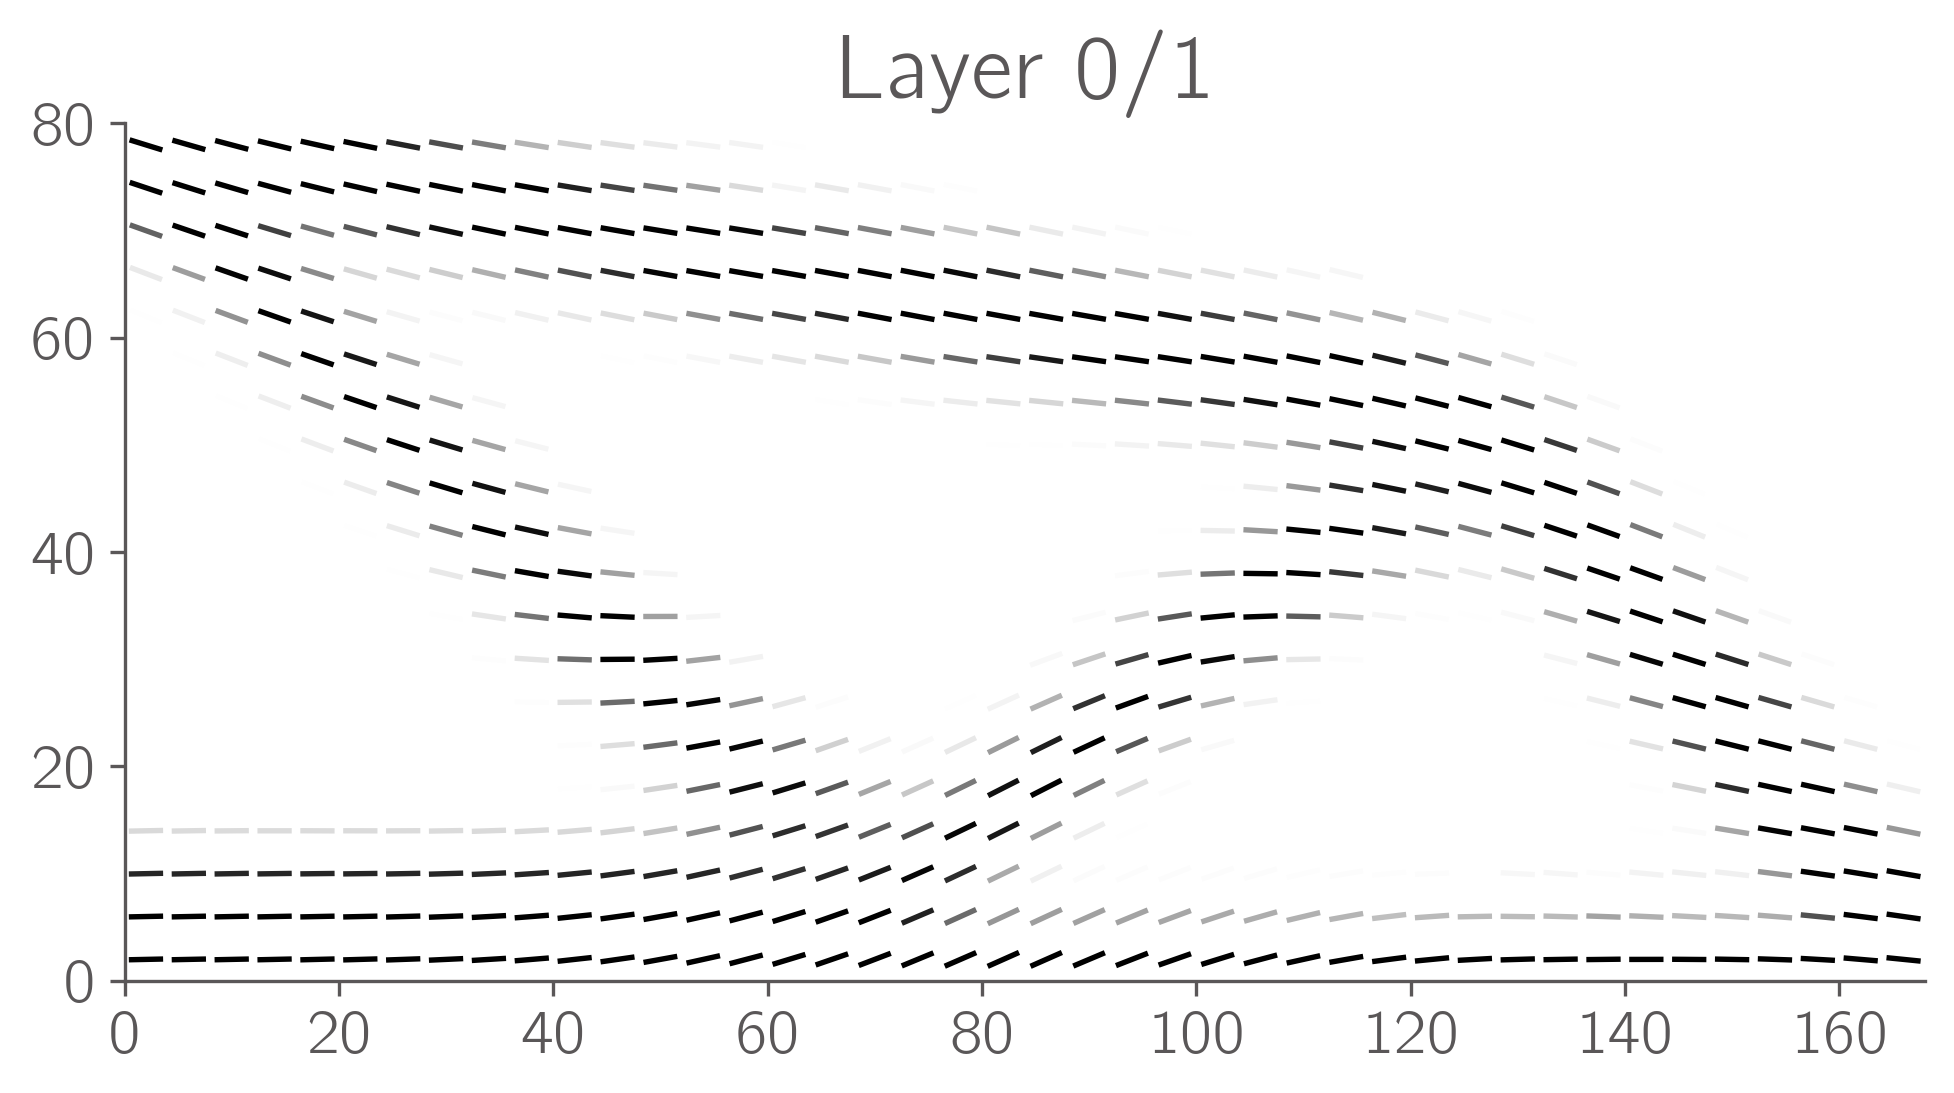

In [5]:
# {t/mm^3, MPa, -, kgCO2/kg}
bamboo     = {'rho': 700e-12, 'E': 17.5e3, 'v': 0.04, 'CO2': 1.0565}
cellulose  = {'rho': 990e-12, 'E': 3.25e3, 'v': 0.355, 'CO2': 3.8}
Vfiber  = 0.5

Ex, Ey, nuxy, nuyz, Gxy, rho, CO2mat = TopOpt.rule_mixtures(fiber=bamboo, matrix=cellulose, Vfiber=Vfiber)
CO2veh = 1030 * 25 * 3.83 # kg_fuel/kg_transported/year * years * kgCO2/kg_fuel = kgCO2/kg

solver = TopOpt(inputfiles='mbb3d', dim='3D_layer', jobname='bamboo', echo=False)
solver.set_material(Ex=Ex, Ey=Ey, nuxy=nuxy, nuyz=nuxy, Gxy=Gxy)
solver.set_volfrac(0.35)
solver.set_filters(r_rho=6, r_theta=40)
solver.set_initial_conditions('random')
solver.set_optim_options(max_iter=150, tol=1e-3, continuation=True)
solver.create_optimizer()

solver.run()
solver.save()
comp = solver.comp_max_hist[-1]
        
post = Post3D(solver)
post.plot_layer(layer=0)

print()
print('Compliance : {:.2f} N.mm'.format(comp))
print('Mass : {:.2f} g'.format(1e6 * solver.get_mass(rho)))
print('CO2 footprint: {:.2f} kgCO2'.format(1000 * solver.get_CO2_footprint(rho, CO2mat, CO2veh)))

# Carbon fibre

Parts with function of providing stiffness, optimisation will search for a target compliance of 1100 N.mm by varying volfrac

- Traditional composite: HM carbon + epoxy, fibre volume fraction 0.5
- Eco-optimised: hemp + PLA, fibre volume fraction 0.5

volfrac = 0.4500, compliance = 1512.32 N.mm
volfrac = 0.5750, compliance = 1251.80 N.mm
volfrac = 0.6375, compliance = 1090.75 N.mm

Compliance : 1090.75 N.mm
Mass : 57.68 g
CO2 footprint: 5688.43 kgCO2


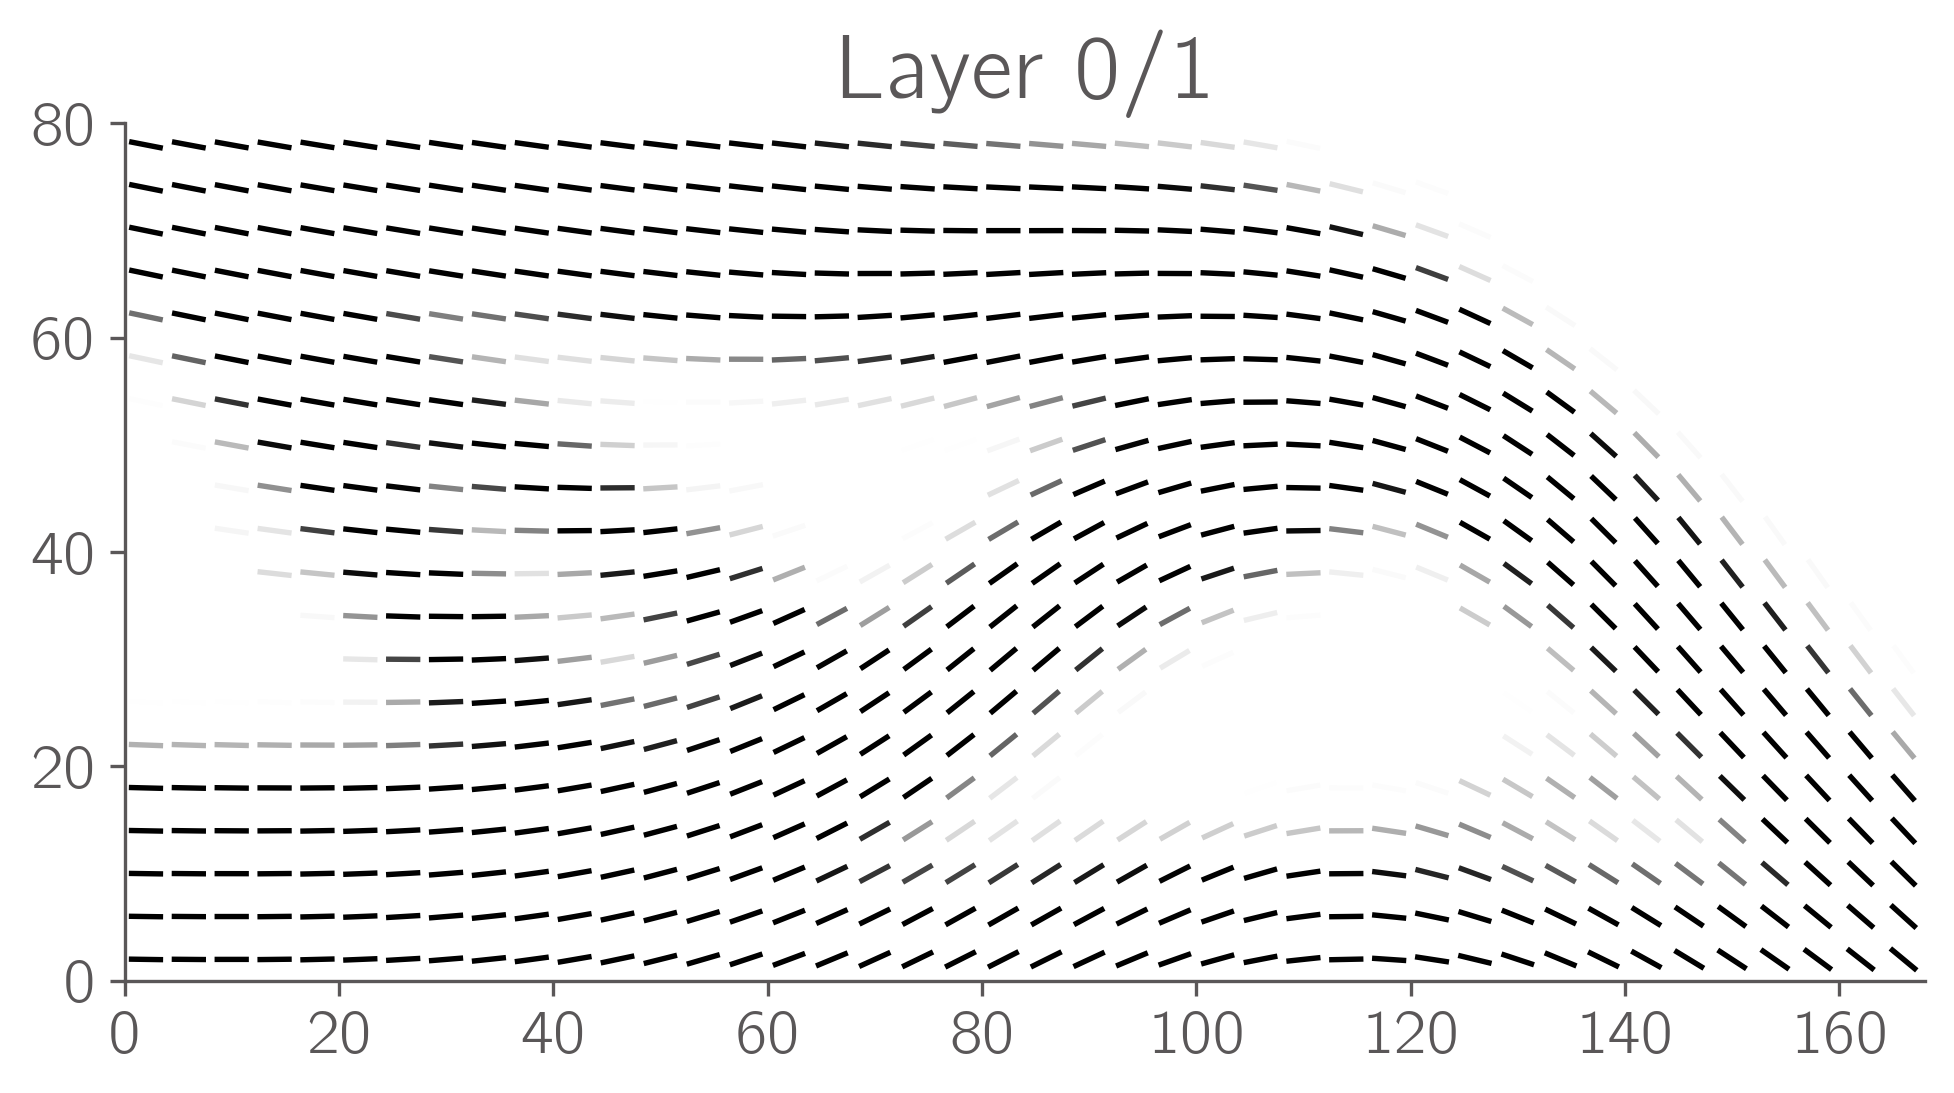

In [6]:
# {t/mm^3, MPa, -, kgCO2/kg}
hmcarbon = {'rho': 2105e-12, 'E': 760e3, 'v': 0.105, 'CO2': 168.1}
epoxy    = {'rho': 1255e-12, 'E': 2.41e3, 'v': 0.399, 'CO2': 5.94}
Vfiber  = 0.5

Ex, Ey, nuxy, nuyz, Gxy, rho, CO2mat = TopOpt.rule_mixtures(fiber=bamboo, matrix=cellulose, Vfiber=Vfiber)
CO2veh = 1030 * 25 * 3.83 # kg_fuel/kg_transported/year * years * kgCO2/kg_fuel = kgCO2/kg

volfracmin = 0.2
volfracmax = 0.7

for i in range(5):
    volfrac = (volfracmin+volfracmax)/2

    solver = TopOpt(inputfiles='mbb3d', dim='3D_layer', jobname='carbon', echo=False)
    solver.set_material(Ex=Ex, Ey=Ey, nuxy=nuxy, nuyz=nuxy, Gxy=Gxy)
    solver.set_volfrac(volfrac)
    solver.set_filters(r_rho=6, r_theta=40)
    solver.set_initial_conditions('random')
    solver.set_optim_options(max_iter=150, tol=1e-3, continuation=True)
    solver.create_optimizer()

    solver.run()
    comp = solver.comp_max_hist[-1]
    
    print('volfrac = {:.4f}, compliance = {:.2f} N.mm'.format(volfrac,comp))

    if comp < 1100:
        volfracmax = volfrac
    else:
        volfracmin = volfrac
    
    if 1050 < comp and comp < 1150:
        break
        
solver.save()

post = Post3D(solver)
post.plot_layer(layer=0)

print()
print('Compliance : {:.2f} N.mm'.format(comp))
print('Mass : {:.2f} g'.format(1e6 * solver.get_mass(rho)))
print('CO2 footprint: {:.2f} kgCO2'.format(1000 * solver.get_CO2_footprint(rho, CO2mat, CO2veh)))

volfrac = 0.3500, compliance = 837.54 N.mm
volfrac = 0.2750, compliance = 1111.14 N.mm

Compliance : 1111.14 N.mm
Mass : 40.71 g
CO2 footprint: 4014.79 kgCO2


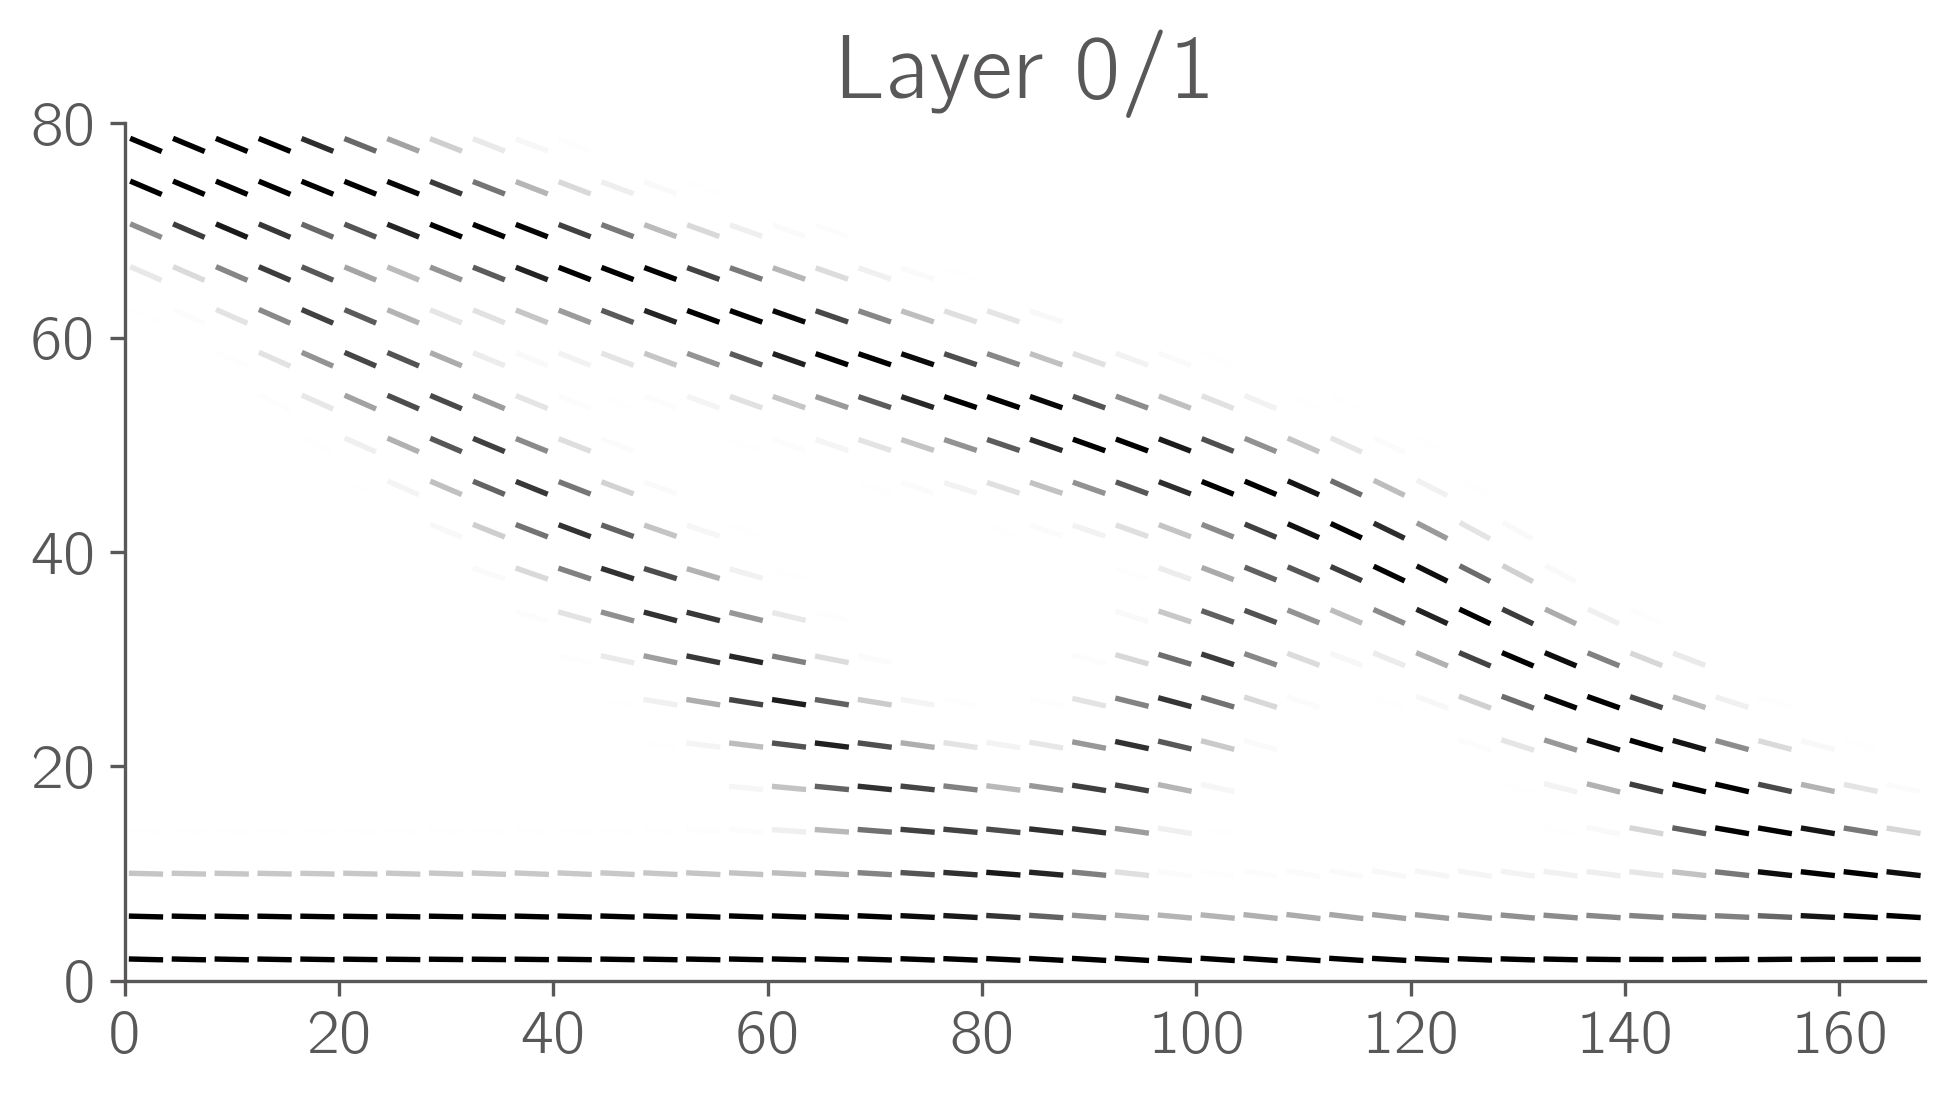

In [8]:
# {t/mm^3, MPa, -, kgCO2/kg}
hemp = {'rho': 1470e-12, 'E': 53.5e3, 'v': 0.355, 'CO2': 0.44}
pla  = {'rho': 1290e-12, 'E': 5.19e3, 'v': 0.39, 'CO2': 2.115}
Vfiber  = 0.5

Ex, Ey, nuxy, nuyz, Gxy, rho, CO2mat = TopOpt.rule_mixtures(fiber=hemp, matrix=pla, Vfiber=Vfiber)
CO2veh = 1030 * 25 * 3.83 # kg_fuel/kg_transported/year * years * kgCO2/kg_fuel = kgCO2/kg

volfracmin = 0.2
volfracmax = 0.5

for i in range(5):
    volfrac = (volfracmin+volfracmax)/2

    solver = TopOpt(inputfiles='mbb3d', dim='3D_layer', jobname='hemp', echo=False)
    solver.set_material(Ex=Ex, Ey=Ey, nuxy=nuxy, nuyz=nuxy, Gxy=Gxy)
    solver.set_volfrac(volfrac)
    solver.set_filters(r_rho=6, r_theta=40)
    solver.set_initial_conditions('random')
    solver.set_optim_options(max_iter=150, tol=1e-3, continuation=True)
    solver.create_optimizer()

    solver.run()
    comp = solver.comp_max_hist[-1]
    
    print('volfrac = {:.4f}, compliance = {:.2f} N.mm'.format(volfrac,comp))

    if comp < 1100:
        volfracmax = volfrac
    else:
        volfracmin = volfrac
    
    if 1050 < comp and comp < 1150:
        break
        
solver.save()

post = Post3D(solver)
post.plot_layer(layer=0)

print()
print('Compliance : {:.2f} N.mm'.format(comp))
print('Mass : {:.2f} g'.format(1e6 * solver.get_mass(rho)))
print('CO2 footprint: {:.2f} kgCO2'.format(1000 * solver.get_CO2_footprint(rho, CO2mat, CO2veh)))